In [1]:
%load_ext autoreload
%autoreload 2
import cbc, cbc_dp
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyqtgraph as pg
import pickle
import pygmo
from numpy import ma
from scipy import constants
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cor_path = "exp_results/scan_{0:05}/scan_corrected_{0:05}.h5"
cor_data_path = 'corrected_data/corrected_data'

f135 = h5py.File(cor_path.format(135), 'r')
b12_cor_data = f135[cor_data_path]

In [3]:
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = np.array([0, 1, 0])
b12_det_pos = np.array([115.3, 129.5, 107.9])
lys_det_pos = np.array([1480 * pix_size, 1155 * pix_size, 150.0])
b12_exp = cbc_dp.ScanSetup(rot_axis=rot_axis,
                           pix_size=pix_size,
                           det_pos=b12_det_pos)
pupil_size = np.radians([0.74, 1.6])

# Cython

In [4]:
%load_ext cython

In [5]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def index_kout_lines(float_t[:, :, ::1] vot_vec, float_t num_ap_x, float_t num_ap_y):
    """
    Return source lines coordinates for a diffraction streaks model

    source - source line origins
    rec_vec - reciprocal vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], kk, i, j, k
        uint8_t[:, ::1] mask = np.zeros((a, b), dtype=np.uint8)
        float_t rec_abs, source_phi, source_th, source_x, source_y, source_z
        float_t source_prd, coeff1, coeff2, alpha, betta, gamma, delta, sol_1, sol_2
        float_t[::1] bounds = np.array([num_ap_x, -num_ap_x, num_ap_y, -num_ap_y], dtype=np.float64)
        float_t[:, :, :, ::1] source_lines = np.zeros((a, b, 2, 3), dtype=np.float64)
    for i in range(a):
        for j in range(b):
            rec_abs = sqrt(vot_vec[i, j, 0]**2 + vot_vec[i, j, 1]**2 + vot_vec[i, j, 2]**2)
            source_phi = atan2(vot_vec[i, j, 1], vot_vec[i, j, 0])
            source_th = acos(-vot_vec[i, j, 2] / rec_abs) - acos(rec_abs / 2)
            source_x = -sin(source_th) * cos(source_phi)
            source_y = -sin(source_th) * sin(source_phi)
            source_z =  cos(source_th)
            source_prd = source_x * vot_vec[i, j, 0] + source_y * vot_vec[i, j, 1] + source_z * vot_vec[i, j, 2]
            kk = 0
            for k in range(4):
                coeff1 = source_prd - bounds[k] * vot_vec[i, j, k // 2]
                coeff2 = vot_vec[i, j, (3 - k) // 2]
                alpha = coeff2**2 + vot_vec[i, j, 2]**2
                betta = coeff2 * coeff1
                gamma = coeff1**2 - vot_vec[i, j, 2]**2 * (1 - bounds[k]**2)
                delta = betta**2 - alpha * gamma
                sol_1 = (betta + sqrt(delta)) / alpha
                sol_2 = (betta - sqrt(delta)) / alpha
                if abs(sol_1) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_1
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_1**2)
                    kk += 1
                if delta != 0 and abs(sol_2) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_2
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_2**2)
                    kk += 1
                if kk == 2:
                    mask[i, j] = 1
                    break
    return np.asarray(source_lines), np.asarray(mask).astype(bool)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def kout_source(float_t[:, :, ::1] kout_exp):
    cdef:
        int a = kout_exp.shape[0], i
        float_t dkout_x, dkout_y, prod, source_x, source_y
        float_t[:, ::1] kout_source = np.empty((a, 3), dtype=np.float64)
    for i in range(a):
        dkout_x = kout_exp[i, 1, 0] - kout_exp[i, 0, 0]
        dkout_y = kout_exp[i, 1, 1] - kout_exp[i, 0, 1]
        prod = kout_exp[i, 1, 0] * dkout_y - kout_exp[i, 1, 1] * dkout_x
        kout_source[i, 0] = dkout_y * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 1] = -dkout_x * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 2] = sqrt(1 - kout_source[i, 0]**2 - kout_source[i, 1]**2)
    return np.asarray(kout_source)

In [6]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def voting_vectors(float_t[:, ::1] kout_exp, float_t[:, ::1] rec_basis, float_t num_ap_x, float_t num_ap_y):
    """
    Return reciprocal lattice voting point for the given experiment outcoming wavevectors kout_exp

    kout_exp - experimental outcoming wavevectors
    rec_basis - reciprocal lattice basis vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int_t a = kout_exp.shape[0], i, ii, jj, kk, h_orig, k_orig, l_orig, h_ind, k_ind, l_ind, ind
        float_t rec_x, rec_y, rec_z, rec_abs, source_th, source_phi
        float_t[:, ::1] inv_basis = np.linalg.inv(rec_basis)
        float_t max_na = max(num_ap_x, num_ap_y)**2 / 2
        int_t h_size = int(ceil(abs(num_ap_x * inv_basis[0, 0] + num_ap_y * inv_basis[1, 0] + max_na * inv_basis[2, 0])))
        int_t k_size = int(ceil(abs(num_ap_x * inv_basis[0, 1] + num_ap_y * inv_basis[1, 1] + max_na * inv_basis[2, 1])))
        int_t l_size = int(ceil(abs(num_ap_x * inv_basis[0, 2] + num_ap_y * inv_basis[1, 2] + max_na * inv_basis[2, 2])))
        float_t[:, :, ::1] vot_vec = np.empty((a, 8 * h_size * k_size * l_size, 3), dtype=np.float64)
    for i in range(a):
        h_orig = int(floor(kout_exp[i, 0] * inv_basis[0, 0] +
                      kout_exp[i, 1] * inv_basis[1, 0] +
                      (kout_exp[i, 2] - 1) * inv_basis[2, 0]))
        k_orig = int(floor(kout_exp[i, 0] * inv_basis[0, 1] +
                      kout_exp[i, 1] * inv_basis[1, 1] +
                      (kout_exp[i, 2] - 1) * inv_basis[2, 1]))
        l_orig = int(floor(kout_exp[i, 0] * inv_basis[0, 2] +
                      kout_exp[i, 1] * inv_basis[1, 2] +
                      (kout_exp[i, 2] - 1) * inv_basis[2, 2]))
        for ii in range(2 * h_size):
            for jj in range(2 * k_size):
                for kk in range(2 * l_size):
                    h_ind = h_orig + ii - h_size + 1
                    k_ind = k_orig + jj - k_size + 1
                    l_ind = l_orig + kk - l_size + 1
                    ind = 4 * k_size * l_size * ii + 2 * l_size * jj + kk
                    rec_x = h_ind * rec_basis[0, 0] + k_ind * rec_basis[1, 0] + l_ind * rec_basis[2, 0]
                    rec_y = h_ind * rec_basis[0, 1] + k_ind * rec_basis[1, 1] + l_ind * rec_basis[2, 1]
                    rec_z = h_ind * rec_basis[0, 2] + k_ind * rec_basis[1, 2] + l_ind * rec_basis[2, 2]
                    rec_abs = sqrt(rec_x**2 + rec_y**2 + rec_z**2)
                    source_th = acos(-rec_z / rec_abs) - acos(rec_abs / 2)
                    source_phi = atan2(rec_y, rec_x)
                    vot_vec[i, ind, 0] = rec_x - sin(source_th) * cos(source_phi)
                    vot_vec[i, ind, 1] = rec_y - sin(source_th) * sin(source_phi)
                    vot_vec[i, ind, 2] = rec_z + cos(source_th)
    return np.array(vot_vec)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def fitness(float_t[:, :, ::1] vot_vec,
            float_t[:, :, ::1] kout_exp,
            float_t num_ap,
            float_t pen_coeff):
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], i, j
        float_t tau_x, tau_y, dk_x, dk_y, fit_x, fit_y, dist
        float_t fitness = 0.0, min_fit, pt_fit
    for i in range(a):
        tau_x = kout_exp[i, 1, 0] - kout_exp[i, 0, 0]
        tau_y = kout_exp[i, 1, 1] - kout_exp[i, 0, 1]
        dk_x = vot_vec[i, 0, 0] - (kout_exp[i, 0, 0] + kout_exp[i, 1, 0]) / 2
        dk_y = vot_vec[i, 0, 1] - (kout_exp[i, 0, 1] + kout_exp[i, 1, 1]) / 2
        fit_x = (dk_x * tau_y**2 - dk_y * tau_y * tau_x) / (tau_x**2 + tau_y**2)
        fit_y = (dk_y * tau_y**2 - dk_x * tau_x * tau_y) / (tau_x**2 + tau_y**2)
        min_fit = sqrt(fit_x**2 + fit_y**2)
        dist = sqrt(dk_x**2 + dk_y**2)
        if dist > num_ap:
            min_fit += pen_coeff * (dist - num_ap)
        for j in range(1, b):
            dk_x = vot_vec[i, j, 0] - (kout_exp[i, 0, 0] + kout_exp[i, 1, 0]) / 2
            dk_y = vot_vec[i, j, 1] - (kout_exp[i, 0, 1] + kout_exp[i, 1, 1]) / 2
            fit_x = (dk_x * tau_y**2 - dk_y * tau_y * tau_x) / (tau_x**2 + tau_y**2)
            fit_y = (dk_y * tau_y**2 - dk_x * tau_x * tau_y) / (tau_x**2 + tau_y**2)
            pt_fit = sqrt(fit_x**2 + fit_y**2)
            dist = sqrt(dk_x**2 + dk_y**2)
            if dist > num_ap:
                pt_fit += pen_coeff * (dist - num_ap)
            if pt_fit < min_fit:
                min_fit = pt_fit
        fitness += min_fit
    return fitness / a

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def fitness_idxs(float_t[:, :, ::1] vot_vec,
                 float_t[:, :, ::1] kout_exp,
                 float_t num_ap,
                 float_t pen_coeff):
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], i, j
        float_t tau_x, tau_y, dk_x, dk_y, fit_x, fit_y, dist
        float_t fitness = 0.0, min_fit, pt_fit
        int_t[::1] idxs = np.empty(a, dtype=np.int64)
    for i in range(a):
        tau_x = kout_exp[i, 1, 0] - kout_exp[i, 0, 0]
        tau_y = kout_exp[i, 1, 1] - kout_exp[i, 0, 1]
        dk_x = vot_vec[i, 0, 0] - kout_exp[i, 0, 0]
        dk_y = vot_vec[i, 0, 1] - kout_exp[i, 0, 1]
        fit_x = (dk_x * tau_y**2 - dk_y * tau_y * tau_x) / (tau_x**2 + tau_y**2)
        fit_y = (dk_y * tau_y**2 - dk_x * tau_x * tau_y) / (tau_x**2 + tau_y**2)
        min_fit = sqrt(fit_x**2 + fit_y**2)
        dist = sqrt(dk_x**2 + dk_y**2)
        if dist > num_ap:
            min_fit += pen_coeff * (dist - num_ap)
        idxs[i] = 0
        for j in range(1, b):
            dk_x = vot_vec[i, j, 0] - kout_exp[i, 0, 0]
            dk_y = vot_vec[i, j, 1] - kout_exp[i, 0, 1]
            fit_x = (dk_x * tau_y**2 - dk_y * tau_y * tau_x) / (tau_x**2 + tau_y**2)
            fit_y = (dk_y * tau_y**2 - dk_x * tau_x * tau_y) / (tau_x**2 + tau_y**2)
            pt_fit = sqrt(fit_x**2 + fit_y**2)
            dist = sqrt(dk_x**2 + dk_y**2)
            if dist > num_ap:
                pt_fit += pen_coeff * (dist - num_ap)
            if pt_fit < min_fit:
                min_fit = pt_fit; idxs[i] = j
    return (np.arange(a), np.asarray(idxs))

# Simulation results

In [2]:
datapath = 'data/data'
res1 = h5py.File('results/diff_08-08-2019_21-53-29.hdf5', 'r')['results/diffracted lightwave values']
file2 = h5py.File('results/diff_07-09-2019_05-32-33.hdf5', 'r')
res3 = h5py.File('results/diff_25-09-2019_08-17-22.hdf5', 'r')[datapath]
res4 = h5py.File('results/diff_07-01-2020_14-41-05.hdf5', 'r')[datapath]
res5 = h5py.File('results/diff_09-01-2020_12-40-10.hdf5', 'r')[datapath]

# Functional optimization

## Present approach

In [9]:
b12_scan = pickle.load(open('exp_results/b12_scan.p', 'rb'))
b12_qs = b12_scan.kout_ref(np.radians(np.arange(101)))
basis_full = b12_qs.index()
rec_basis_full = cbc.rec_basis(basis_full)
b12_setup = cbc_dp.IndexSetup(det_pos=b12_det_pos, num_ap=0.9 * pupil_size, pix_size=pix_size)

In [9]:
frame_idx = 0
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=1))
start_point = np.concatenate((np.zeros(3), rec_sizes, np.zeros(3)))
rot_tf = cbc_dp.RCBI(lines=b12_scan[frame_idx].raw_lines,
                     setup=b12_setup,
                     rec_basis=rec_basis,
                     tol=(0.05, 0.07, 0.1))

algo = pygmo.algorithm(pygmo.de(gen=2000))
algo.set_verbosity(100)
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=36)
pop = algo.evolve(pop)
print(prob.fitness(start_point), pop.champion_f)

[0.01995262] [0.00183016]


In [10]:
frame_idx = 40
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
start_point = np.concatenate((np.zeros(3), rec_basis.ravel()))
full_tf = cbc_dp.FCBI(lines=b12_scan[frame_idx].raw_lines,
                      setup=b12_setup,
                      rec_basis=rec_basis,
                      tol=(0.1, 0.1))

algo = pygmo.algorithm(pygmo.de(gen=2000))
algo.set_verbosity(100)
prob = pygmo.problem(full_tf)
pop = pygmo.population(prob, size=36)
pop = algo.evolve(pop)
champion = pop.champion_x
print(prob.fitness(start_point), pop.champion_f)

[0.01355099] [0.00219304]


In [11]:
model_streaks = cbc_dp.RectModel(full_tf.rec_basis(champion), 0.9 * pupil_size, 0.7).kout_lines()
model_kout = cbc_dp.RectModel(full_tf.rec_basis(champion), 0.9 * pupil_size, 0.7).kout()
model_lines = full_tf.setup.det_pts(model_streaks, champion)
model_pts = full_tf.setup.det_pts(model_kout, champion)

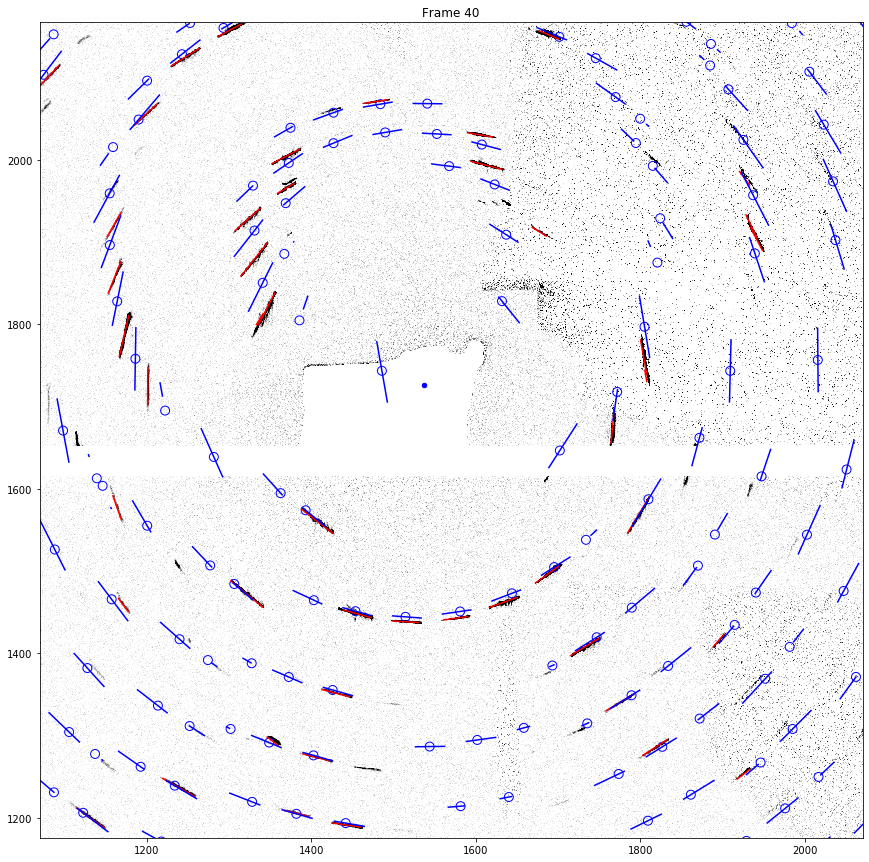

In [12]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
for line in b12_scan[frame_idx]:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
ax.set_xlim(1070, 2070)
ax.set_ylim(1176, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [13]:
taus = (kout_exp[:, 1] - kout_exp[:, 0])
taus = taus / np.sqrt((taus**2).sum(axis=1))[:, None]
delta_k = kout_src - kout_exp[:, 0]
fit = abs(delta_k - (delta_k * taus).sum(axis=1)[:, None] * taus)

NameError: name 'kout_exp' is not defined

In [14]:
kout_exp = full_tf.kout_exp(champion)
kout_src = kout_source(kout_exp)
det_src = full_tf.setup.det_pts(kout_src, champion)
vot_vec = voting_vectors(kout_exp.mean(axis=1),
                         full_tf.rec_basis(champion),
                         full_tf.setup.num_ap[0],
                         full_tf.setup.num_ap[1])[full_tf.idxs(champion)[0]]
det_vot = full_tf.setup.det_pts(vot_vec, champion)

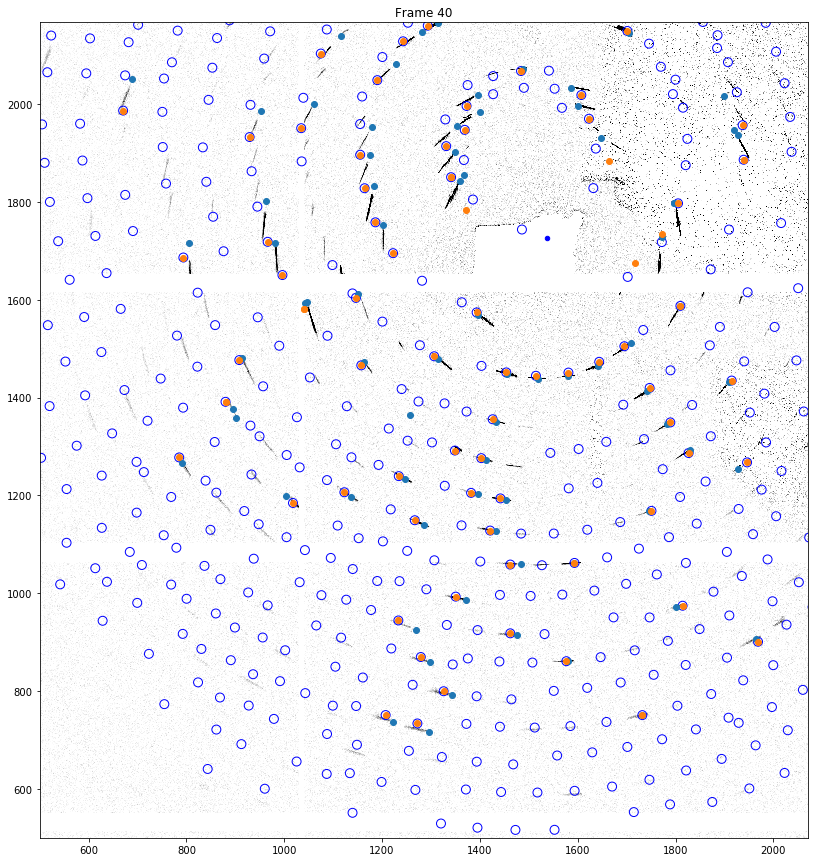

In [16]:
%matplotlib inline

exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
ax.scatter(det_src[:, 0], det_src[:, 1])
ax.scatter(det_vot[:, 0], det_vot[:, 1])
ax.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
ax.set_xlim(500, 2070)
ax.set_ylim(500, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [45]:
isl = pygmo.island(algo=pygmo.de(2000), prob=prob, size=36, udi=pygmo.mp_island())

In [15]:
islands = []
for idx, b12_frame in enumerate(b12_scan):
    rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(idx)).T)
    full_tf = cbc_dp.FCBI(lines=b12_frame.raw_lines,
                          setup=b12_setup,
                          rec_basis=rec_basis,
                          tol=(0.15, 0.15))
    prob = pygmo.problem(full_tf)
    islands.append(pygmo.island(algo=pygmo.de(2000), prob=prob, size=36, udi=pygmo.mp_island()))

In [16]:
for island in islands:
    island.evolve()
for island in islands:
    island.wait()

In [22]:
index_sol = np.stack([island.get_population().champion_x for island in islands], axis=1)

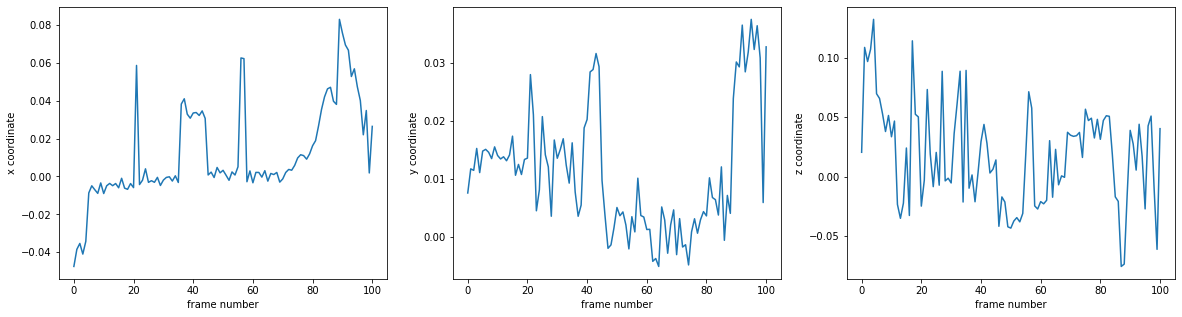

In [36]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, coord in zip(axes, index_sol[:3]):
    ax.plot(coord)
    ax.set_xlabel('frame number')
axes[0].set_ylabel('x coordinate')
axes[1].set_ylabel('y coordinate')
axes[2].set_ylabel('z coordinate')
plt.show()

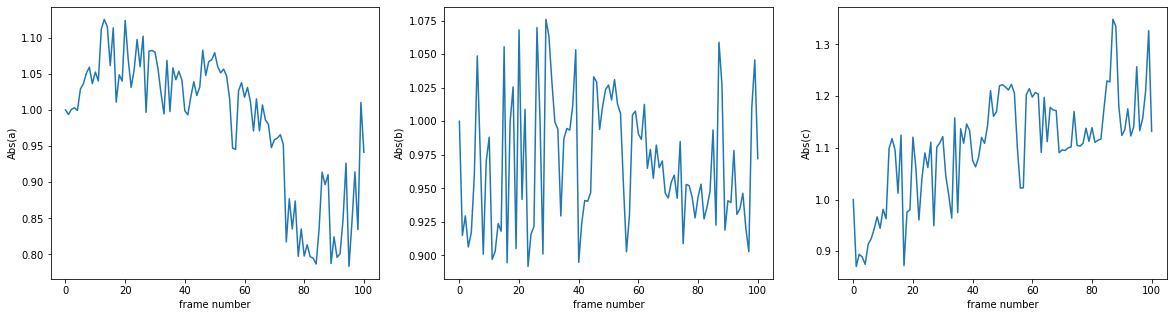

In [37]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
rec_sizes = np.sqrt((index_sol[3:, :].reshape((3, 3, 101))**2).sum(axis=0))
rec_sizes = rec_sizes / rec_sizes[:, 0][:, None]
for ax, size in zip(axes, rec_sizes):
    ax.plot(size)
    ax.set_xlabel('frame number')
axes[0].set_ylabel('Abs(a)')
axes[1].set_ylabel('Abs(b)')
axes[2].set_ylabel('Abs(c)')
plt.show()

In [225]:
b12_det_pos_ref = np.array([115.3, 129.5, 107.9])
b12_det_pos_ref

array([115.3, 129.5, 107.9])

In [ ]:
index_file = h5py.File('exp_results/b12_index_results.h5py', 'w')
index_file

## Modelling approach

In [10]:
from abc import ABCMeta, abstractmethod

class AbcCBI(metaclass=ABCMeta):
    """
    Abstract Convergent beam indexer (CBI) class

    lines - detected diffraction streaks positions at the detector [pixels]
    setup - IndexSetup class object
    rec_basis - Reciprocal lattice basis vectors matrix
    tol - tolerance defining vector bounds
    pen_coeff - fitness penalty coefficient
    """
    mat_shape = (3, 3)
    lower_b, upper_b = None, None

    def __init__(self, lines, setup, rec_basis, tol):
        self.lines, self.setup = lines, setup
        self._init_bounds(rec_basis, tol)
        self.num_ap = np.sqrt(setup.num_ap[0]**2 + setup.num_ap[1]**2)

    @abstractmethod
    def _init_bounds(self, rec_basis, tol):
        pass

    @abstractmethod
    def rec_basis(self, vec):
        pass

    def kout_exp(self, vec):
        """
        Generate the experimentally measured deiffraction streaks outcoming wavevectors
        """
        return self.setup.kout_exp(self.lines, vec)
    
    def voting_vectors(self, vec, kout_exp):
        """
        Return the reciprocal lattice voting points for the given experimental outcoming
        wavevectors kout_exp
        """
        return voting_vectors(kout_exp=kout_exp.mean(axis=1),
                                 rec_basis=self.rec_basis(vec),
                                 num_ap_x=self.setup.num_ap[0],
                                 num_ap_y=self.setup.num_ap[1])

    def get_bounds(self):
        """
        Return the TF argument vector bounds
        """
        return (self.lower_b, self.upper_b)

    def fitness(self, vec):
        """
        Return the target function value for a vector
        """
        kout_exp = self.kout_exp(vec)
        vot_vec = self.voting_vectors(vec, kout_exp)
        return [fitness(vot_vec=vot_vec,
                        kout_exp=kout_exp,
                        num_ap=self.num_ap,
                        pen_coeff=10)]

    def idxs(self, vec):
        """
        Return the indices of the optimal reciprocal lattice voting vectors
        """
        kout_exp = self.kout_exp(vec)
        vot_vec = self.voting_vectors(vec, kout_exp)
        return fitness_idxs(vot_vec=vot_vec,
                            kout_exp=kout_exp,
                            num_ap=self.num_ap,
                            pen_coeff=10)

    def gradient(self, d_vec):
        """
        Return the target function gradient value
        """
        return pygmo.estimate_gradient(self.fitness, d_vec)

    def get_name(self):
        return "A convergent beam indexing problem"

class FCBI(AbcCBI):
    """
    Convergent beam crystallography indexer class
    Argument vector is comprised of detector relative position
    and full reciprocal basis vectors matrix

    lines                           - detected diffraction streaks positions at the detector
                                      [mm]
    setup                           - IndexSetup class object
    rec_basis                       - Reciprocal lattice basis vectors matrix
    tol = (pos_tol, rb_tol)         - relative detector position and
                                      reciprocal basis matrix tolerances [0.0 - 1.0]
    pen_coeff                       - fitness penalty coefficient
    """
    def __init__(self, lines, setup, rec_basis, tol=(0.1, 0.05)):
        super(FCBI, self).__init__(lines, setup, rec_basis.ravel(), tol)

    def _init_bounds(self, rec_basis, tol):
        rb_bounds = np.stack(((1 - tol[1]) * rec_basis, (1 + tol[1]) * rec_basis))
        self.lower_b = np.concatenate((-tol[0] * np.ones(3), rb_bounds.min(axis=0)))
        self.upper_b = np.concatenate((tol[0] * np.ones(3), rb_bounds.max(axis=0)))

    def rec_basis(self, vec):
        """
        Return rectangular lattice basis vectors for a vector
        """
        return vec[3:].reshape(self.mat_shape)

    def get_extra_info(self):
        return "Dimensions: 12 in total\n3 - detector position\n9 - reciprocal lattice basis vectors matrix"

In [11]:
frame_idx = 0
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
start_point = np.concatenate((np.zeros(3), rec_basis.ravel()))
full_tf = FCBI(lines=b12_scan[frame_idx].raw_lines,
               setup=b12_setup,
               rec_basis=rec_basis,
               tol=(0.1, 0.1))

algo = pygmo.algorithm(pygmo.de(gen=2500))
algo.set_verbosity(100)
prob = pygmo.problem(full_tf)
pop = pygmo.population(prob, size=36)
pop = algo.evolve(pop)
champion = pop.champion_x
print(prob.fitness(start_point), prob.fitness(champion))

[0.06005197] [0.00335979]


In [13]:
model_streaks = cbc_dp.RectModel(full_tf.rec_basis(champion), 0.9 * pupil_size, 0.7).kout_lines()
model_kout = cbc_dp.RectModel(full_tf.rec_basis(champion), 0.9 * pupil_size, 0.7).kout()
model_lines = full_tf.setup.det_pts(model_streaks, champion)
model_pts = full_tf.setup.det_pts(model_kout, champion)

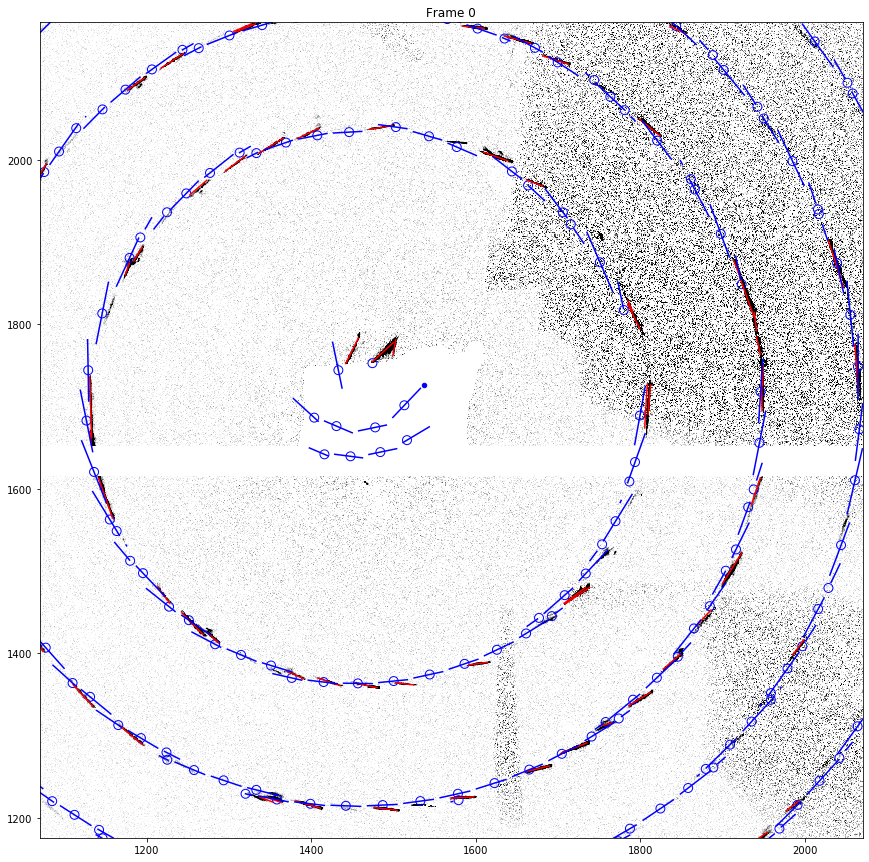

In [14]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
for line in b12_scan[frame_idx]:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
ax.set_xlim(1070, 2070)
ax.set_ylim(1176, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [25]:
kout_exp = full_tf.kout_exp(champion)
kout_src = kout_source(kout_exp)
det_src = full_tf.setup.det_pts(kout_src, champion)
vot_vec = voting_vectors(kout_exp.mean(axis=1),
                         full_tf.rec_basis(champion),
                         full_tf.setup.num_ap[0],
                         full_tf.setup.num_ap[1])[full_tf.idxs(champion)]
det_vot = full_tf.setup.det_pts(vot_vec, champion)

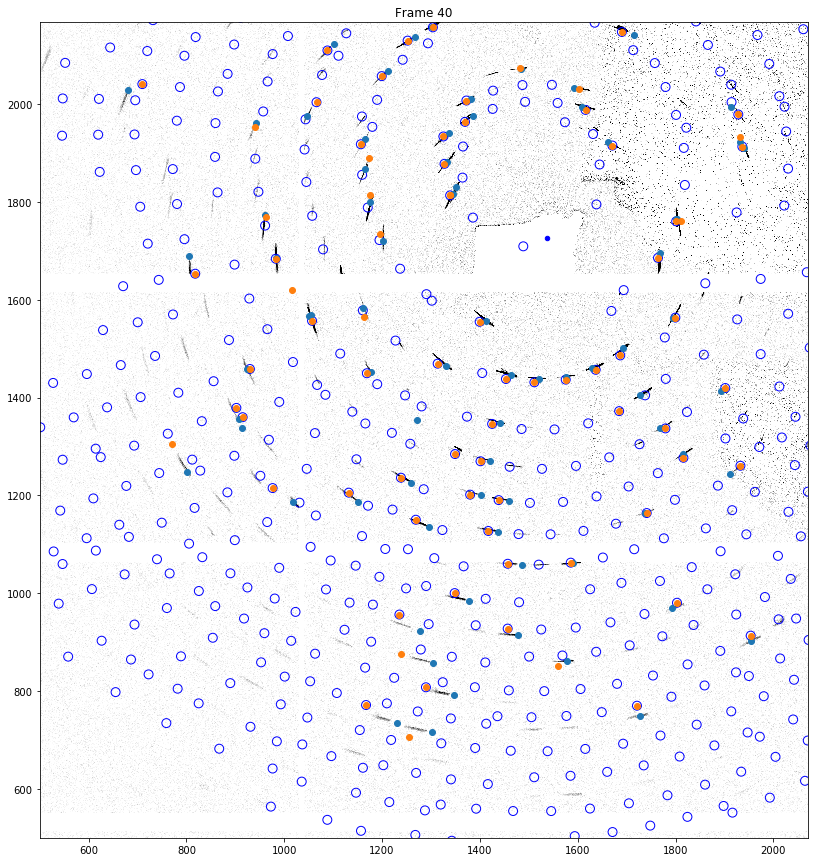

In [26]:
%matplotlib inline

exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
ax.scatter(det_src[:, 0], det_src[:, 1])
ax.scatter(det_vot[:, 0], det_vot[:, 1])
ax.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
ax.set_xlim(500, 2070)
ax.set_ylim(500, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [15]:
islands = []
for idx, b12_frame in enumerate(b12_scan):
    rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(idx)).T)
    full_tf = FCBI(lines=b12_frame.raw_lines,
                   setup=b12_setup,
                   rec_basis=rec_basis,
                   tol=(0.1, 0.1))
    prob = pygmo.problem(full_tf)
    islands.append(pygmo.island(algo=pygmo.de(2000), prob=prob, size=36, udi=pygmo.mp_island()))

In [ ]:
for island in islands:
    island.evolve()
for island in islands:
    island.wait()

In [43]:
islands[0].evolve()
print(islands[0])

Island name: Multiprocessing island
	Status: busy - **error occurred**

Extra info:
	Using a process pool: yes
	Number of processes in the pool: 12

Algorithm: DE: Differential Evolution

Problem: A convergent beam indexing problem

Replacement policy: Fair replace

Selection policy: Select best

Population size: 36
	Champion decision vector: [-0.0537318, 0.0299485, -0.00189639, -0.00762378, 0.0494771, ... ]
	Champion fitness: [0.0181211]



In [32]:
index_sol = np.stack([island.get_population().champion_x for island in islands], axis=1)

# Gaussian beam

In [38]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def R(zs, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    return zs + zr**2 / zs

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

def gaussian(xs, ys, zs, waist=1e-4, wavelength=1.5e-7):
    k = 2 * np.pi / wavelength
    zr = np.pi * waist**2 / wavelength
    Rs = zs + zr**2 / zs
    wz = waist * sqrt(1 + z**2 / zr**2)
    return np.pi**-1 * waist**-1 * wz**-1 * np.exp(-(xs**2 + ys**2) / wz**2) * np.exp(-1j * (k * z - np.arctan(zs / zr) + k * (xs**2 + ys**2) / 2 / Rs))

In [39]:
thdiv(waist, wavelength)

0.0477464829275686

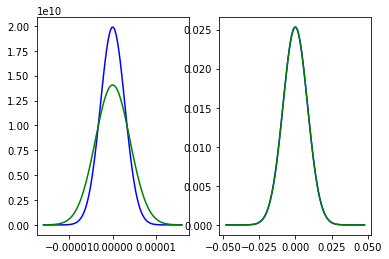

In [50]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
us2 = np.abs(cbc.gaussian(xs, 0, zR(waist, wavelength), waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
ufs2 = np.abs(cbc.gaussian_f(kxs, 0, zR(waist, wavelength), waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us, 'b-', xs, us2, 'g-')
ax2.plot(kxs, ufs, 'b-', kxs, ufs2, 'g-')
plt.show()

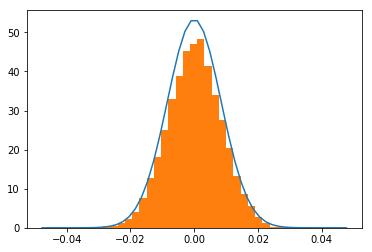

In [34]:
%matplotlib inline
knum = 10000
ks = cbc.gaussian_dist(knum, 0, waist, wavelength)
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength))
us = np.abs(cbc.gaussian_f(kxs, 0, 10, waist, wavelength)) * 4 * np.pi / thdiv(waist, wavelength)*2
plt.plot(kxs, us)
plt.hist(ks[:,0], 30, density=True)
plt.show()

In [ ]:
%matplotlib inline
_thdiv = thdiv(waist,wavelength)
kxs, kys = cbc.uniform_dist(100000, waist, wavelength)[:, 0:2].T
kxs2, kys2 = cbc.gaussian_dist(100000, waist, wavelength)[:, 0:2].T
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.hist2d(kxs, kys, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
ax2.hist2d(kxs2, kys2, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
plt.show()

# Convolution approximation and Henry's equations

In [3]:
def gaussian_dist(N, z, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    wz = waist * np.sqrt(1 + z**2 / zr**2)
    thdiv = wavelength / np.pi / wz
    kxs, kys = np.random.multivariate_normal([0, 0], [[thdiv**2 / 2, 0], [0, thdiv**2 / 2]], N).T
    return cbc.kout_parax(kxs, kys)

In [40]:
waist = 3e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 10, 10, 1
detNx, detNy = 64, 64
pix_size = 2 * 55e-3
det_dist = 30
knum = 5000

In [4]:
%matplotlib inline
XS, YS, ZS = np.array([0, 0.5 * a]), np.zeros(2), np.zeros(2)
els = ['Au', 'Ag']; bs = np.zeros(2)
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz, XS, YS, ZS)
z0 = 1e-4
zs += z0
asf_coeffs = cbc.asf_coeffs(els, bs)
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
print(asf_coeffs.shape)

(2, 11)


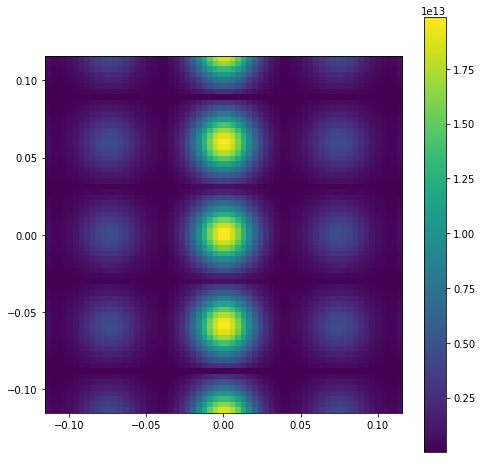

In [80]:
qabs = cbc.utils.q_abs(kouts, kins, wavelength)
asfs = cbc.utils.asf_sum(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs * us * phs).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(8, 8))
plt.imshow(ints, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

In [81]:
%time kjs = np.repeat(cbc.gaussian_dist(knum, waist, wavelength)[:,np.newaxis], xs.shape[-1], axis=1)
%time qabs2 = cbc.utils.q_abs(kouts, kjs, wavelength)
%time asfs2 = cbc.utils.asf_sum(qabs2, asf_coeffs)
%time phs2 = cbc.utils.phase_conv(kouts, kjs, xs, ys, zs, wavelength)
%time sfs2 = asfs2 * phs2
print(kjs.shape, qabs2.shape, asfs2.shape, phs2.shape)

CPU times: user 1.13 ms, sys: 533 µs, total: 1.66 ms
Wall time: 1.13 ms
CPU times: user 480 ms, sys: 203 ms, total: 683 ms
Wall time: 680 ms
CPU times: user 2.03 s, sys: 102 ms, total: 2.13 s
Wall time: 2.12 s
CPU times: user 1min 16s, sys: 416 ms, total: 1min 17s
Wall time: 1min 16s
CPU times: user 248 ms, sys: 197 ms, total: 445 ms
Wall time: 443 ms
(5000, 2, 3) (4096, 5000, 2) (4096, 5000, 2) (4096, 5000, 2)


In [82]:
uphs = cbc.gaussian_f(kjs[:,:,0], kjs[:,:,1], z0, waist, wavelength)
res2 = (uphs * sfs2).sum(axis=(-2,-1)).reshape(kxs.shape) / kjs.shape[0]
print(uphs.shape, res2.shape)

(5000, 2) (64, 64)


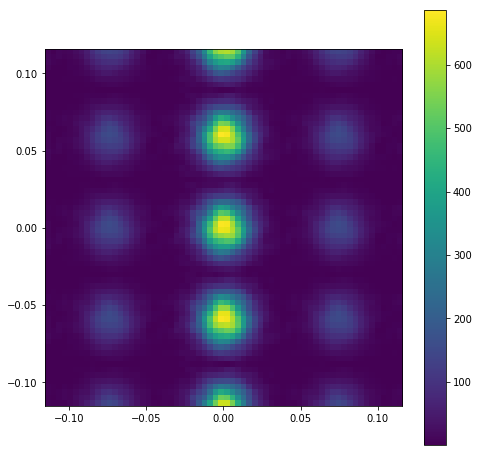

In [83]:
ints2 = np.abs(res2)
plt.figure(figsize=(8, 8))
plt.imshow(ints2, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

# Lysozyme diffraction pattern

In [42]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2.2e-2, 1e-4
waist = 4.5e-6
a, b, c = np.array([7.9e-6, 0, 0]), np.array([0, 7.9e-6, 0]), np.array([0, 0, 3.8e-6])
Nx, Ny, Nz = 20, 20, 20
r = 2e-4
detNx, detNy = 512, 512
pix_size = 55e-3
det_dist = 60

In [44]:
bragg = wavelength / 2 / np.sqrt(a.dot(a))
th_lens = 2 * ap / f
th_lens2 = 2 * wavelength / np.pi / waist
print(2 * bragg / th_lens, 2 * bragg / pix_size * det_dist)

0.863060989643268 20.713463751438432


In [45]:
beam = cbc.CircBeam(f, ap, wavelength)
diff = cbc.Diff(beam=beam,
                detector=cbc.Detector(det_dist=det_dist, detNx=detNx, detNy=detNy, pix_size=pix_size),
                lattice=cbc.BallLattice(cell=cbc.Cell.importpdb('4et8.pdb'), a=a, b=b, c=c, r=r))

In [ ]:
diffres = diff.calculate().pool()
diffres.write()

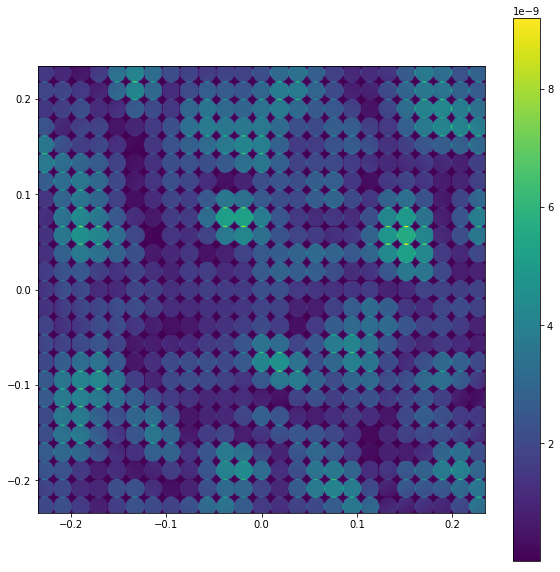

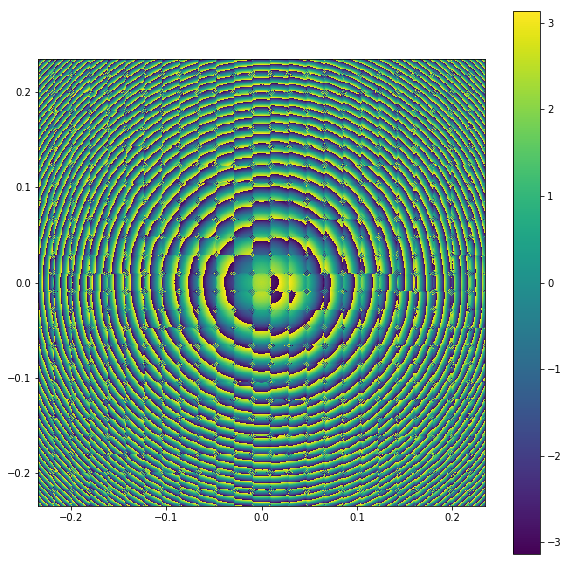

In [76]:
ints = np.abs(data[0])
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()
ang1 = np.angle(data[0])
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

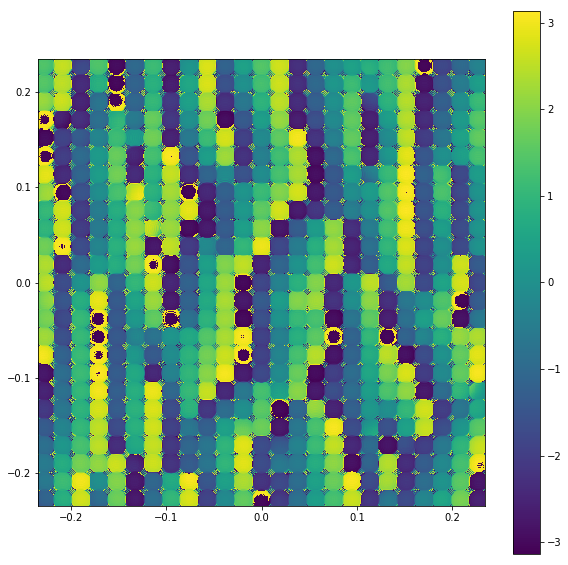

In [157]:
ang2 = np.angle(data[0] / np.exp(2j * np.pi / wavelength * 1e-4 * (1 - (data[1]**2 + data[2]**2) / 2)))
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

# Output values at the centers of diffraction orders

In [19]:
import numba as nb
from math import exp, cos, sin, pi

In [24]:
@nb.njit(nb.float64[:,:](nb.float64[:], nb.float64[:,:]), fastmath=True)
def asf_sum(ss, asfcoeffs):
    a = ss.size
    b = asfcoeffs.shape[0]
    asfs = np.empty((a, b), dtype=np.float64)
    ss = np.ascontiguousarray(ss)
    asfcoeffs = np.ascontiguousarray(asfcoeffs)
    for i in range(a):
        for j in range(b):
            dasf = 0.0
            for k in range(5):
                dasf += asfcoeffs[j,k] * exp(-ss[i]**2 * asfcoeffs[j,6+k])
            asfs[i,j] = (dasf + asfcoeffs[j,5]) * exp(-ss[i]**2 * asfcoeffs[j,-1])
    return asfs

@nb.njit(nb.complex128[:,:](nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64), fastmath=True)
def phase(kouts, xs, ys, zs, wavelength):
    a = kouts.shape[0]
    b = xs.size
    res = np.empty((a, b), dtype=np.complex128)
    kouts = np.ascontiguousarray(kouts)
    xs = np.ascontiguousarray(xs)
    ys = np.ascontiguousarray(ys)
    zs = np.ascontiguousarray(zs)
    for i in range(a):
        for j in range(b):
            _ph = kouts[i,0] * xs[j] + kouts[i,1] * ys[j] + kouts[i,2] * zs[j]
            res[i,j] = cos(2 * pi / wavelength * _ph) + sin(2 * pi / wavelength * _ph) * 1j
    return res

def gaussian_f(kxs, kys, zs, wavelength):
    return np.exp(-2j * np.pi / wavelength * np.multiply.outer((kxs**2 + kys**2) / 2, zs))

In [11]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2e-2, 1e-4
waist = 6.5e-6
a, b, c = 7.9e-6, 7.9e-6, 3.8e-6
Nx, Ny, Nz = 20, 20, 1
H, K = 10, 10
pix_size = 1/a
det_dist = 1/wavelength

In [28]:
XS = np.array([-0.5*a, -0.5*a, 0.5*a, 0.5*a])
YS = np.array([-0.5*a, 0.5*a, -0.5*a, 0.5*a])
ZS = np.array([-0.9*c, -0.9*c, 0.9*c, 0.9*c])
bs = np.repeat(25, 4)
elems = ['Au', 'Ag', 'Au', 'Ag']

In [7]:
XS = np.array([-0.5*a, 0.5*a])
YS = np.array([0.5*a, -0.5*a])
ZS = np.array([-0.9*c, 0.9*c])
bs = np.repeat(25, 2)
elems = ['Au', 'Ag']

In [29]:
beam = cbc.GausBeam(waist, wavelength)
diff = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff.move_lat([0.5 * a, 0.5 * b, 1e-3])

In [30]:
diffres = diff.henry().pool()
res, kxs, kys = diffres.res, diffres.kxs, diffres.kys

In [31]:
XS, YS, ZS, bs, elems = cbc.utils.pdb.importpdb('4et8.pdb')
gxs, gys = cbc.det_kouts(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size)
gs = np.stack((gxs.ravel(), gys.ravel(), np.repeat(0, gxs.size)), axis=-1)
ss = np.sqrt(gs*gs).sum(axis=-1) / wavelength / 2e7
asfcoeffs = cbc.asf_coeffs(elems, bs, wavelength)
asfs = asf_sum(ss.ravel(), asfcoeffs)
phs = phase(gs, XS, YS, ZS, wavelength)
ufs = gaussian_f(gxs.ravel(), gys.ravel(), ZS, wavelength)
Fs = (asfs * phs * ufs).sum(axis=-1).reshape(gxs.shape)
print(asfs.shape, phs.shape, ufs.shape, Fs.shape)

(441, 1001) (441, 1001) (441, 1001) (21, 21)


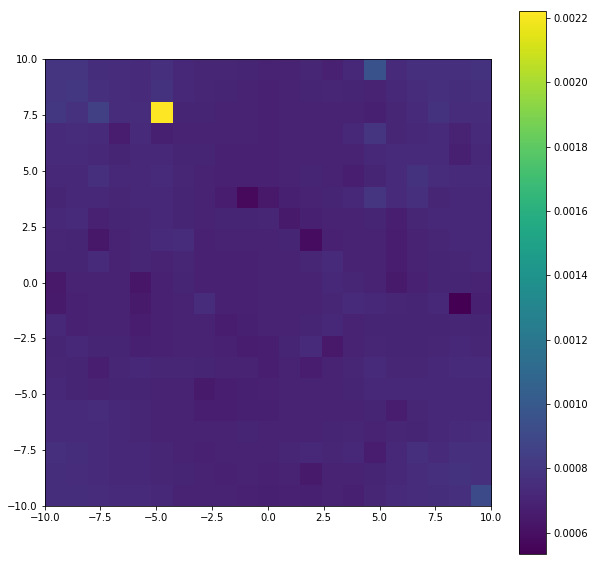

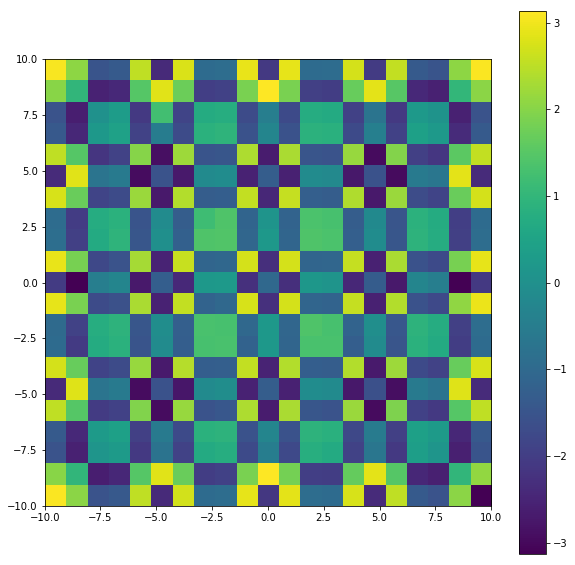

In [32]:
ints2 = np.abs(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ints2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang2 = np.angle(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

# Output values in overlap regions

In [153]:
diff2 = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff2.move_lat([0.5 * a, 0.5 * b, 0.0])

In [154]:
diffres2 = diff2.henry().pool()
res2, kxs2, kys2 = diffres2.res, diffres2.kxs, diffres2.kys

In [142]:
kouts = cbc.kout_parax(kxs2.ravel(), kys2.ravel())
gxs1, gys1 = gxs[:, 0:2*H], gys[:, 0:2*H]
gxs2, gys2 = gxs[:, 1:2*H+1], gys[:, 1:2*H+1]
gs1 = np.stack((gxs1.ravel(), gys1.ravel(), np.repeat(0, gxs1.size)), axis=-1)
gs2 = np.stack((gxs2.ravel(), gys2.ravel(), np.repeat(0, gxs2.size)), axis=-1)
ss1 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
ss2 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
asfs1 = asf_sum(ss1.ravel(), asfcoeffs)
asfs2 = asf_sum(ss2.ravel(), asfcoeffs)
phs1 = phase(gs1, XS, YS, ZS, wavelength)
phs2 = phase(gs2, XS, YS, ZS, wavelength)
ufs1 = gaussian_f(gxs1.ravel(), gys1.ravel(), ZS, wavelength)
ufs2 = gaussian_f(gxs2.ravel(), gys2.ravel(), ZS, wavelength)
Fs1 = (asfs1 * phs1 * ufs1).sum(axis=-1).reshape(gxs1.shape)
Fs2 = (asfs2 * phs2 * ufs2).sum(axis=-1).reshape(gxs2.shape)
OLs = Fs1 + Fs2

In [10]:
ints4 = np.abs(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ints4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang4 = np.angle(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ang4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

NameError: name 'OLs' is not defined

# Lens beam

In [70]:
wavelength = 1.5e-7
f, ap, defoc = 2, 8e-2, 1e-4
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 128, 128
pix_size = 55e-3 / 2
det_dist = 30

In [71]:
print(wavelength / a, 2 * ap / f)

0.075 0.08


In [79]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs += 1e-4
xs -= 0.5001 * a
ys -= 0.5001 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
Rs = np.sqrt(xs**2 + ys**2 + zs**2)
kins = cbc.lensbeam_kins(xs, ys, zs, f, wavelength)
us = cbc.cbeam(xs, ys, zs, f, ap, wavelength)

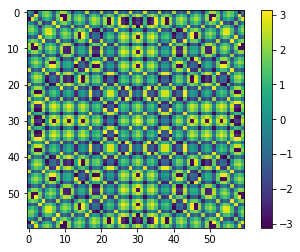

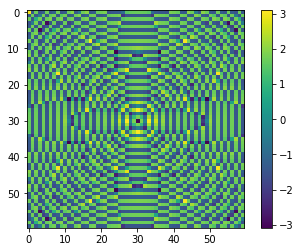

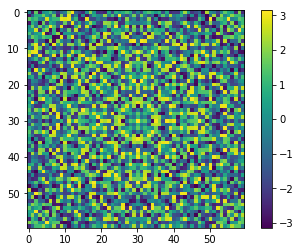

In [80]:
phin1 = (np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)).reshape((Nx, Ny))
angs1 = np.angle(phin1)
angs2 = np.angle(np.exp(1j * np.pi) * np.exp(-1j * np.pi * 1e-2 / wavelength * (xs**2 + ys**2) / Rs**2)).reshape((Nx, Ny))
angs3 = -np.angle(us).reshape(Nx, Ny)
plt.imshow(angs1)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()
plt.imshow(angs2)
plt.colorbar()
plt.show()

In [82]:
qs_abs = cbc.utils.q_abs(kouts, kins, wavelength)
asf_coeffs1 = cbc.asf_coeffs()
%time asfs1 = cbc.utils.asf_sum(qs_abs, asf_coeffs1)
qs_abs.shape

CPU times: user 3.03 s, sys: 141 ms, total: 3.17 s
Wall time: 3.16 s


(16384, 3600, 1)

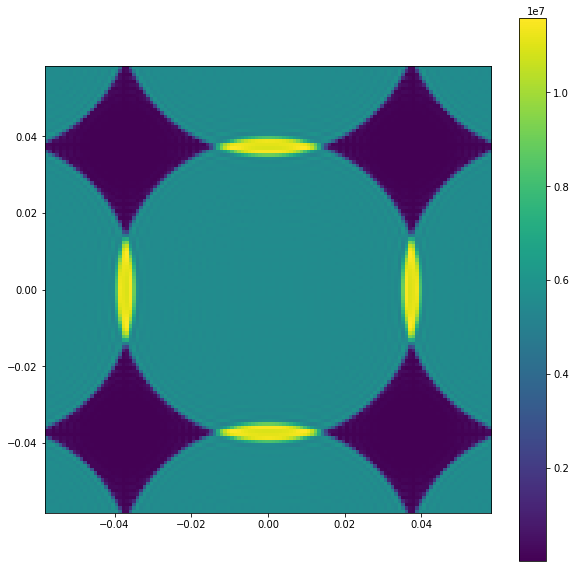

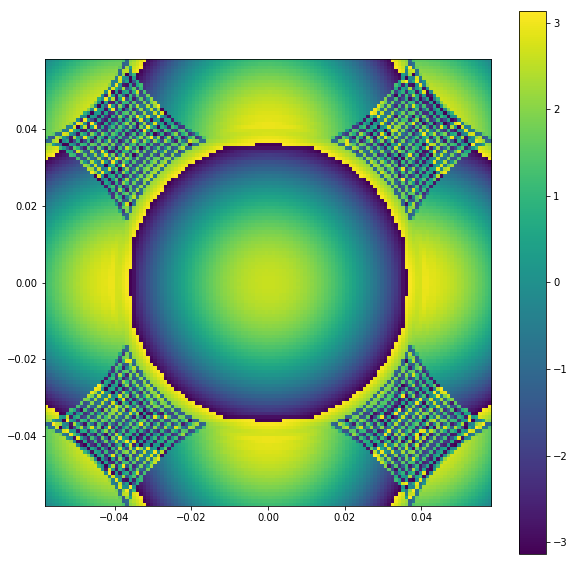

In [85]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

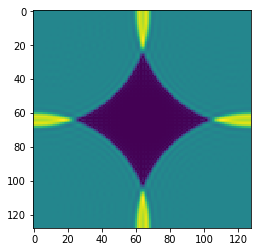

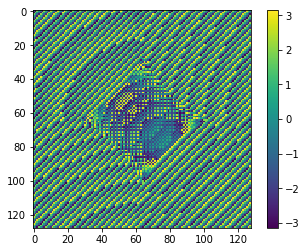

In [86]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()